In [1]:
import pickle
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation
import numpy as np
import seaborn as sns

In [2]:
binary = os.path.join(os.getcwd(), 'data', 'volve_compiled.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    data = pickle.load(bin_file)

/mnt/d/OneDrive/Mestrado/Semestre 02/SYSID/SYSID_Trabalho/Volve-Dataset/data/volve_compiled.pkl


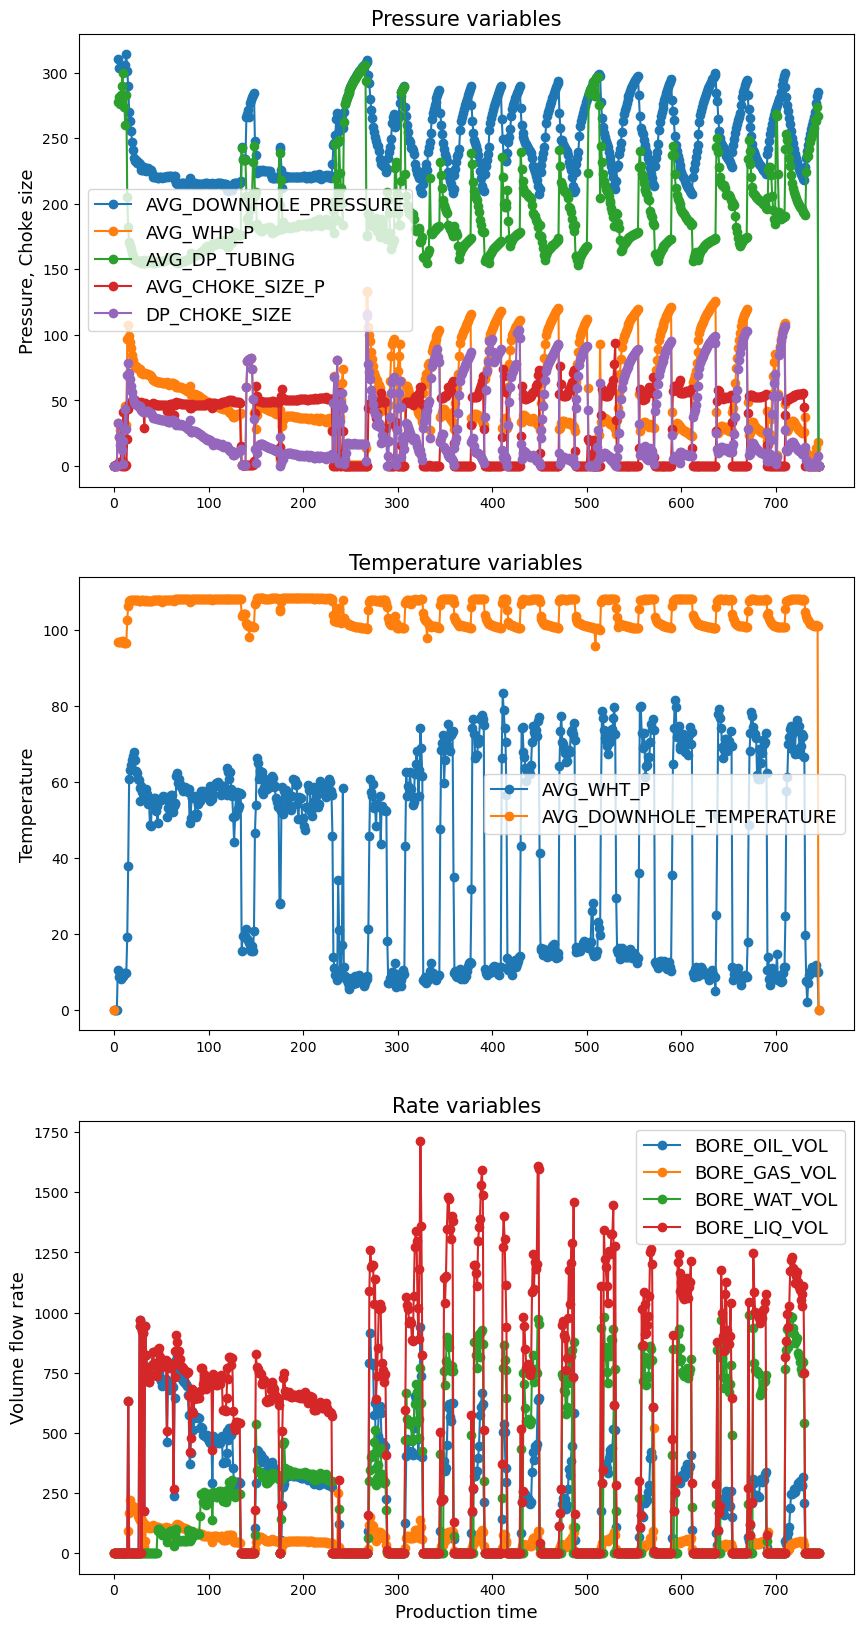

In [3]:
case = "15/9-F-1 C"
#case = "15/9-F-11"

data_case = data['OP'][case]

filt_vars_IN_Q =  [
        'BORE_OIL_VOL',
        'BORE_GAS_VOL',
        'BORE_WAT_VOL',
        #'BORE_OIL_CUM',
        #'BORE_LIQ_CUM',
        #'BORE_GAS_CUM',
        #'BORE_WAT_CUM',
]

filt_vars_IN_QINJ = [
        #'BORE_WI_VOL',
        #'BORE_WI_CUM',
]

filt_vars_IN_P = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        'AVG_DP_TUBING',
        #'AVG_ANNULUS_PRESS',
        'AVG_CHOKE_SIZE_P',
        'DP_CHOKE_SIZE',
]

filt_vars_IN_T = [
        'AVG_WHT_P',
        'AVG_DOWNHOLE_TEMPERATURE',
]

filt_vars_OUT = [
        'BORE_OIL_VOL',
        'BORE_GAS_VOL',
        'BORE_WAT_VOL',
        'BORE_LIQ_VOL',
]

time = data_case['N']
fig, ax = plt.subplots(3,1, figsize=(10, 20))
for var in filt_vars_IN_P:
    ax[0].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_T:
    ax[1].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_OUT:
    ax[2].plot(time, data_case[var], '-o', label=var)
#for var in filt_vars_OUT:
#    ax[3].plot(time, data_case[var], '-o', label=var)
title_font = 15
label_font = 13
ax[0].set_title(f'Pressure variables', fontsize=title_font)
ax[1].set_title(f'Temperature variables', fontsize=title_font)
ax[2].set_title(f'Rate variables', fontsize=title_font)
ax[0].set_ylabel('Pressure, Choke size', fontsize=label_font)
ax[1].set_ylabel('Temperature', fontsize=label_font)
ax[2].set_ylabel('Volume flow rate', fontsize=label_font)
ax[2].set_xlabel('Production time', fontsize=label_font)
ax[0].legend(fontsize=label_font)
ax[1].legend(fontsize=label_font)
ax[2].legend(fontsize=label_font)

In [4]:
prefix = 'MISO.W1'
binary = os.path.join(os.getcwd(), 'outputs', f'{prefix}_ml.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    X1_tr, y_tr, X1_te, y_te, results, order_progression = pickle.load(bin_file)

/mnt/d/OneDrive/Mestrado/Semestre 02/SYSID/SYSID_Trabalho/Volve-Dataset/outputs/MISO.W1_ml.pkl


/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model_pars = []
yhats = []
for index, row in pd.DataFrame(results).iterrows():
    yhats.append([f"{row['MODEL']}.{prefix}",row['MODEL OBJ'].predict(X1_te, y_te),row['MODEL OBJ'].predict(X1_te, y_te, steps_ahead=1)])
    try:
        model_pars.append((f"{row['MODEL']}.{prefix}", row['MODEL OBJ'].estimator.cv_results_))
    except Exception as e: 
        print(e)


'str' object has no attribute 'cv_results_'
'str' object has no attribute 'cv_results_'


In [6]:
prefix = 'SISO.W1'
binary = os.path.join(os.getcwd(), 'outputs', f'{prefix}_ml.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    X1_tr, y_tr, X1_te, y_te, results, order_progression = pickle.load(bin_file)

/mnt/d/OneDrive/Mestrado/Semestre 02/SYSID/SYSID_Trabalho/Volve-Dataset/outputs/SISO.W1_ml.pkl


In [7]:
for index, row in pd.DataFrame(results).iterrows():
    yhats.append([f"{row['MODEL']}.{prefix}",row['MODEL OBJ'].predict(X1_te, y_te),row['MODEL OBJ'].predict(X1_te, y_te, steps_ahead=1)])
    try:
        model_pars.append((f"{row['MODEL']}.{prefix}", row['MODEL OBJ'].estimator.cv_results_))
    except Exception as e: 
        print(e)

'str' object has no attribute 'cv_results_'
'str' object has no attribute 'cv_results_'


In [8]:
cv_errors = {
    'MODEL' : [],
    'INPUTS': [],
    'SPLIT' : [],
    'R2 SCORE': [],
            }

mlp_data = {
    'INPUTS' : [],
    'R2 MEAN SCORE' : [],
    'R2 STD DEV' : []
    }

times = {
    'MODEL':[],
    'INPUTS': [],
    'TIME MEAN' :[],
    'TIME STD': []
}
for model, model_par in model_pars:
    if 'MLP' in model:
        r2_scores = model_par['mean_test_score'].tolist()
        r2_scores_std = model_par['std_test_score'].tolist()
        n_r2 = len(r2_scores)
        mlp_data['INPUTS'].extend([model.split('.')[1]]*n_r2)
        mlp_data['R2 MEAN SCORE'].extend(r2_scores)
        mlp_data['R2 STD DEV'].extend(r2_scores_std)
    best_model = np.where(model_par['rank_test_score'] == 1)[0]
    times['MODEL'].append(model.split('.')[0])
    times['INPUTS'].append(model.split('.')[1])
    times['TIME MEAN'].append(model_par['mean_fit_time'][best_model][0])
    times['TIME STD'].append(model_par['std_fit_time'][best_model][0])
    for key in model_par.keys():
        if 'split' in key and '_test_score' in key:
            cv_errors['MODEL'].append(model.split('.')[0])
            cv_errors['INPUTS'].append(model.split('.')[1])
            cv_errors['SPLIT'].append(int(key.split('_')[0][5:]))
            cv_errors['R2 SCORE'].append(model_par[key][best_model][0])
        elif 'MLP' in model and 'param_' in key:
            pname = key[6:]
            if not pname in mlp_data.keys():
                try:
                    mlp_data[pname] = model_par[key].tolist()
                except Exception:
                    mlp_data[pname] = model_par[key]
            else:
                try:
                    mlp_data[pname].extend(model_par[key].tolist())
                except Exception:
                    mlp_data[pname].extend(model_par[key])
            
            

cv_errors = pd.DataFrame(cv_errors)
mlp_data['hidden_layers'] = [len(x) for x in mlp_data['hidden_layer_sizes']]
mlp_data['total_hidden_units'] = [np.sum(x) for x in mlp_data['hidden_layer_sizes']]
mlp_data = pd.DataFrame(mlp_data)
mlp_data.drop(columns=['activation', 'max_iter', 'solver'], inplace=True)
display(mlp_data)

,INPUTS,R2 MEAN SCORE,R2 STD DEV,alpha,batch_size,early_stopping,hidden_layer_sizes,tol,hidden_layers,total_hidden_units
0,MISO,0.696466,0.061074,0.030304,256,False,"(80, 40, 40, 100)",3.019659e-03,4,260
1,MISO,0.773943,0.065139,0.034329,32,True,"(80, 80, 20, 20)",1.643129e-05,4,200
2,MISO,0.778440,0.057495,0.086851,128,False,"(20, 100, 40, 60)",2.306157e-06,4,220
3,MISO,0.756186,0.068448,0.004190,32,False,"(60, 40, 100)",1.917448e-06,3,200
4,MISO,0.725941,0.079741,0.001361,32,True,"(60, 100)",3.058823e-04,2,160
...,...,...,...,...,...,...,...,...,...,...
195,SISO,0.639130,0.048117,0.348421,32,False,"(100, 60, 60, 20)",2.154966e-02,4,240
196,SISO,0.713169,0.076433,0.000114,64,False,"(20, 80, 60, 60)",1.092597e-06,4,220
197,SISO,0.762604,0.065102,0.053043,32,False,"(100, 60, 40, 80)",1.110901e-05,4,280
198,SISO,0.717133,0.081320,0.023639,256,False,"(80, 80, 60, 40)",8.299463e-07,4,260


<AxesSubplot: xlabel='MODEL', ylabel='R2 SCORE'>

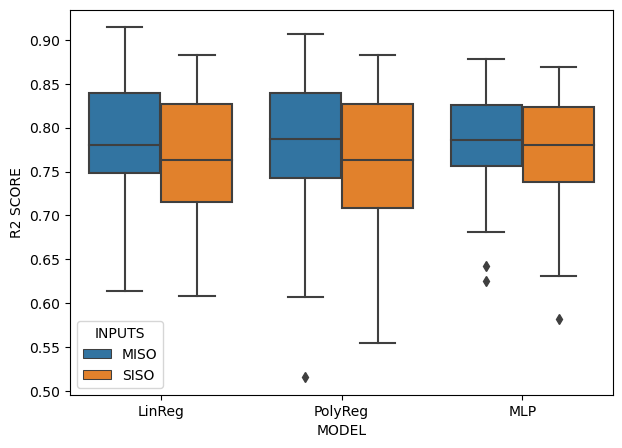

In [26]:
cv_errors_filt = cv_errors[
    (cv_errors.MODEL == 'LinReg')|
    (cv_errors.MODEL == 'PolyReg')|
    (cv_errors.MODEL == 'MLP')
]
fig, axs = plt.subplots(1,1, figsize=(7,5))
sns.boxplot(data=cv_errors_filt, x='MODEL', y='R2 SCORE', hue='INPUTS', ax=axs)

<AxesSubplot: xlabel='R2 MEAN SCORE', ylabel='alpha'>

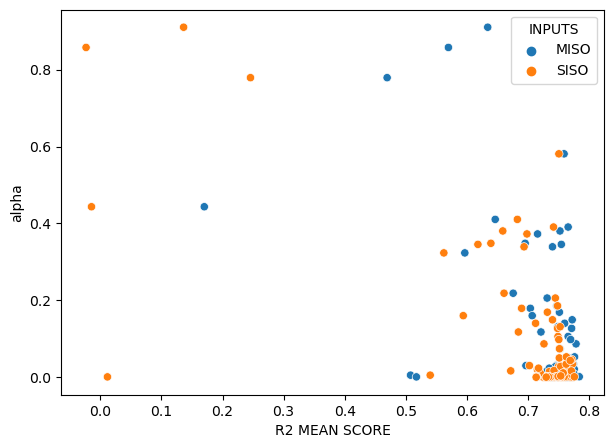

In [10]:
fig, axs = plt.subplots(1,1, figsize=(7,5))
sns.scatterplot(
    mlp_data,
    x = 'R2 MEAN SCORE',
    y = 'alpha',
    hue= 'INPUTS',
    ax=axs
)

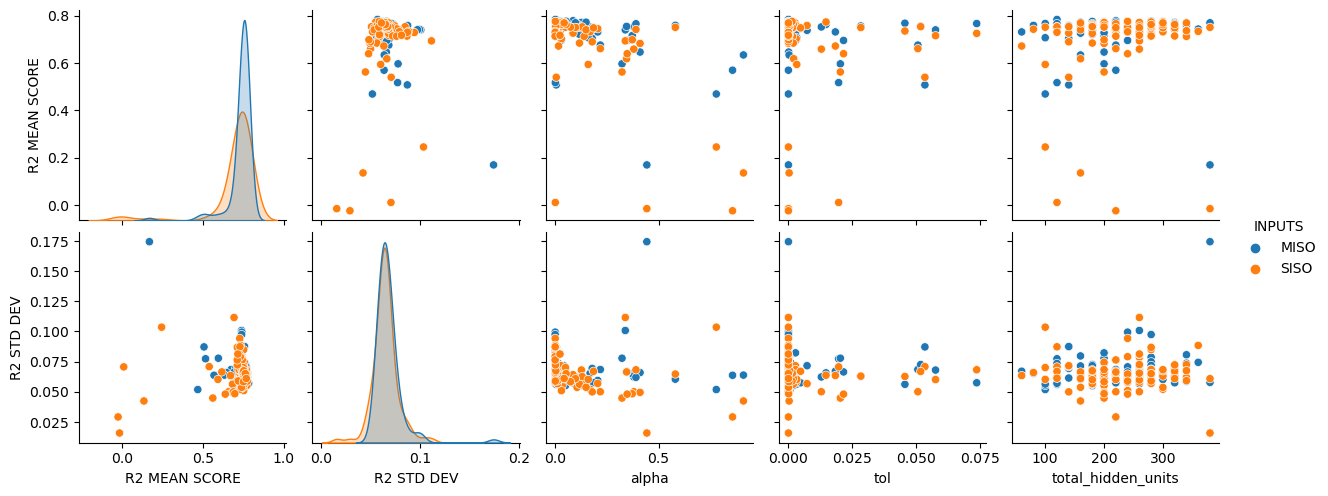

In [11]:
sns.pairplot(mlp_data, x_vars=['R2 MEAN SCORE', 'R2 STD DEV', 'alpha', 'tol', 'total_hidden_units'],  y_vars=['R2 MEAN SCORE', 'R2 STD DEV'], hue='INPUTS')

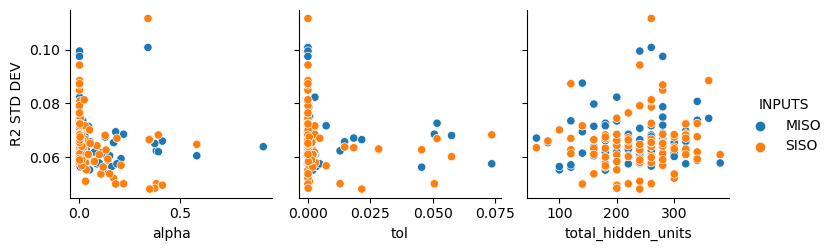

In [12]:
sns.pairplot(mlp_data[mlp_data['R2 MEAN SCORE'] >= 0.6], x_vars=['alpha', 'tol', 'total_hidden_units'],  y_vars=['R2 STD DEV'], hue='INPUTS')

In [13]:
pd.DataFrame(times)

,MODEL,INPUTS,TIME MEAN,TIME STD
0,LinReg,MISO,0.001315,0.000217
1,PolyReg,MISO,0.036452,0.014905
2,SVM,MISO,0.006312,0.001225
3,KNN,MISO,0.000818,0.000858
4,DecisionTree,MISO,0.001265,0.000303
5,RandomForest,MISO,0.191897,0.030525
6,GradientBoosting,MISO,1.377703,0.087340
7,ExtraTrees,MISO,0.110058,0.013610
8,MLP,MISO,0.367222,0.128127
9,LinReg,SISO,0.001091,0.000232


LinReg.MISO.W1
RMSE Train (OSA): 0.11687916201972154
RMSE Full  (OSA): 0.1237881566143333
RMSE Train (FS):  0.17009306265743868
RMSE Full  (FS):  0.17457514437914726
LinReg.SISO.W1
RMSE Train (OSA): 0.12551809732214314
RMSE Full  (OSA): 0.12932128524742822
RMSE Train (FS):  0.2092463636721591
RMSE Full  (FS):  0.21250203994029113


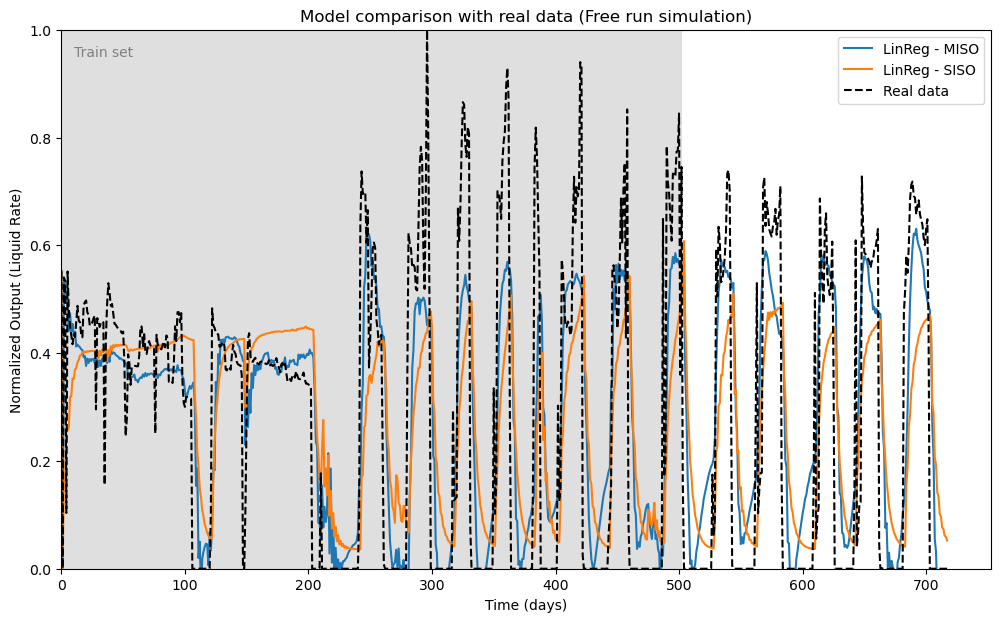

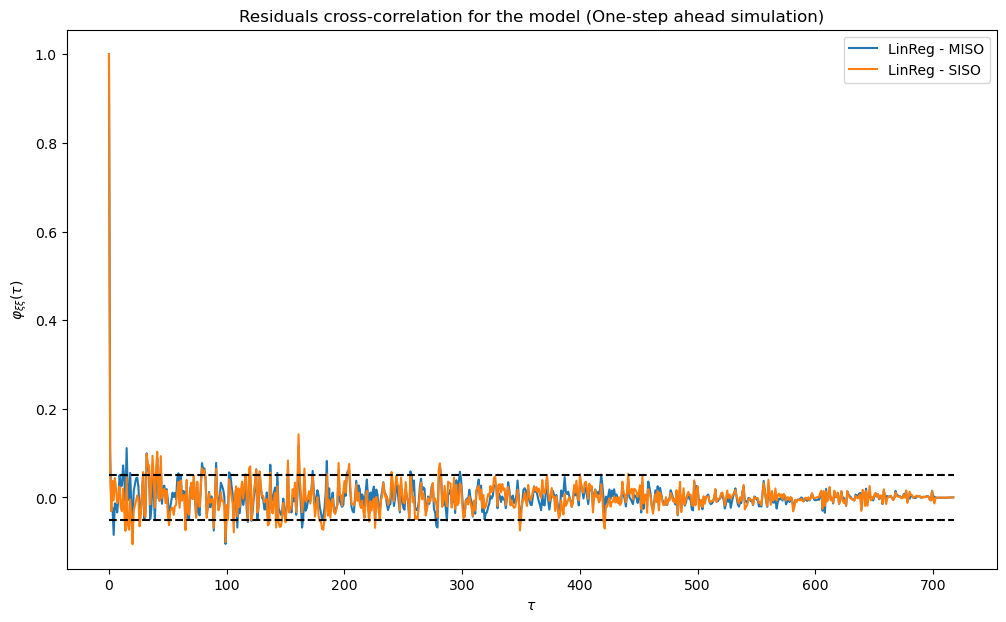

In [14]:
fig, ax   = plt.subplots(1,1, figsize=(12,7))
fig2, ax2 = plt.subplots(1,1, figsize=(12,7))
for model, yhat, yhat_OSA in yhats:
    model_name = model.split('.')[0]
    #if not model_name in ['PolyReg', 'LinReg', 'MLP']: continue
    if not 'LinReg' in model: continue
    ax.plot(yhat, label=' - '.join(model.split('.')[:-1]))
    ee = compute_residues_autocorrelation(y_te, yhat_OSA)
    ax2.plot(ee[0], label=' - '.join(model.split('.')[:-1]))
    print(model)
    print('RMSE Train (OSA):', mean_squared_error(y_te.ravel()[:502], yhat_OSA.ravel()[:502])**0.5)
    print('RMSE Full  (OSA):', mean_squared_error(y_te.ravel(), yhat_OSA.ravel())**0.5)
    print('RMSE Train (FS): ', mean_squared_error(y_te.ravel()[:502], yhat.ravel()[:502])**0.5)
    print('RMSE Full  (FS): ', mean_squared_error(y_te.ravel(), yhat.ravel())**0.5)
ax.plot(y_te, 'k--', label='Real data')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Normalized Output (Liquid Rate)')
ax.set_title('Model comparison with real data (Free run simulation)')
ax.fill_between(np.arange(0, len(yhat)), 0, 1, where = np.arange(0, len(yhat))<=502,
                facecolor ='grey', alpha = 0.25)
ax.legend()
ax.set_xlim(0,None)
ax.set_ylim(0,1)
ax.text(10, 0.95, 'Train set', color='grey')
ax2.set_xlabel('$\\tau$')
ax2.set_ylabel('$\\varphi_{\\xi\\xi}(\\tau)$')
ax2.set_title('Residuals cross-correlation for the model (One-step ahead simulation)')
ax2.legend()
ax2.hlines(0.05, 0, len(y_te), 'k', 'dashed')
ax2.hlines(-0.05, 0, len(y_te), 'k', 'dashed')

MLP.MISO.W1
RMSE Train (OSA): 0.0844208743016248
RMSE Full  (OSA): 0.10524949866680008
RMSE Train (FS):  0.1389216299352147
RMSE Full  (FS):  0.1526218486549162
MLP.SISO.W1
RMSE Train (OSA): 0.11144494718780414
RMSE Full  (OSA): 0.12340840871546883
RMSE Train (FS):  0.1627501819958334
RMSE Full  (FS):  0.1633585978672286


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

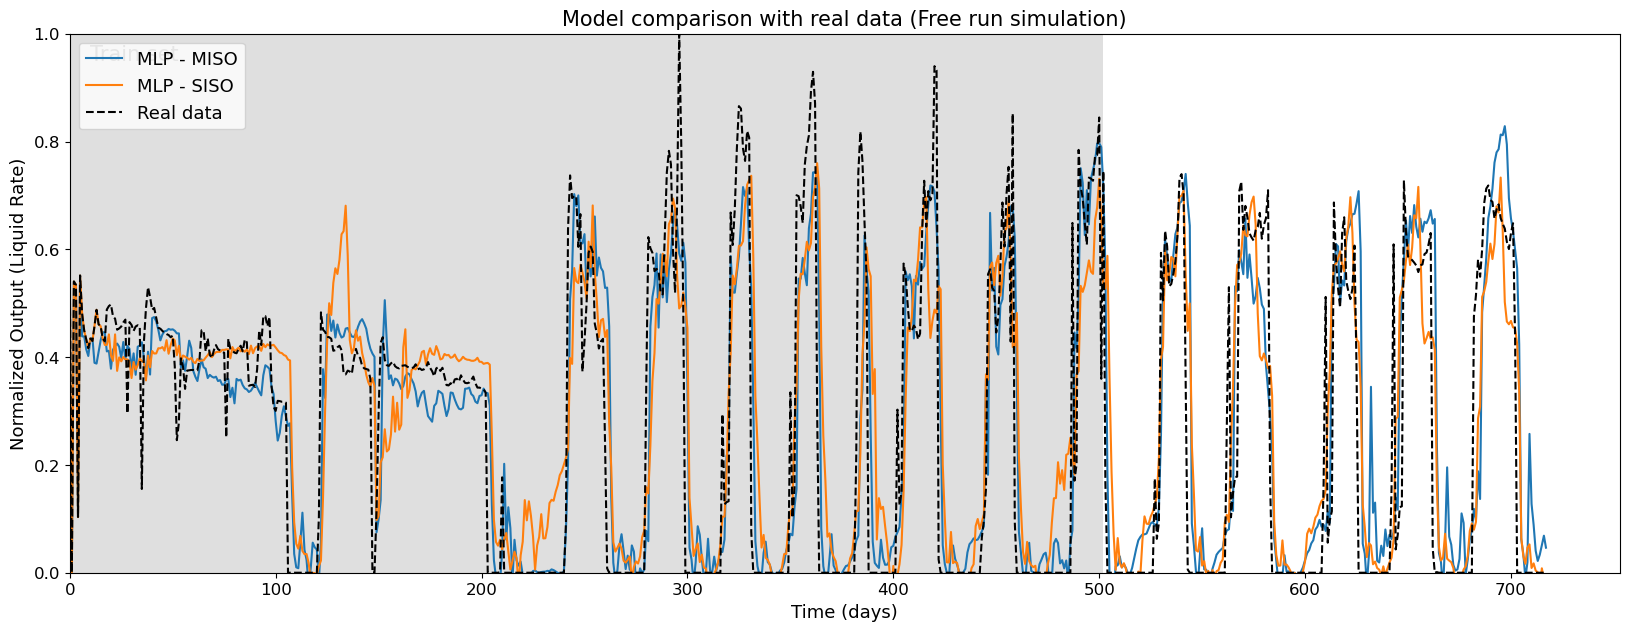

In [25]:
fig, ax   = plt.subplots(1,1, figsize=(20,7))
for model, yhat, yhat_OSA in yhats:
    model_name = model.split('.')[0]
    #if not model_name in ['PolyReg', 'LinReg', 'MLP']: continue
    if not 'MLP' in model: continue
    ax.plot(yhat, label=' - '.join(model.split('.')[:-1]))
    print(model)
    print('RMSE Train (OSA):', mean_squared_error(y_te.ravel()[:502], yhat_OSA.ravel()[:502])**0.5)
    print('RMSE Full  (OSA):', mean_squared_error(y_te.ravel(), yhat_OSA.ravel())**0.5)
    print('RMSE Train (FS): ', mean_squared_error(y_te.ravel()[:502], yhat.ravel()[:502])**0.5)
    print('RMSE Full  (FS): ', mean_squared_error(y_te.ravel(), yhat.ravel())**0.5)
ax.plot(y_te, 'k--', label='Real data')
ax.set_xlabel('Time (days)', fontsize=label_font)
ax.set_ylabel('Normalized Output (Liquid Rate)', fontsize=label_font)
ax.set_title('Model comparison with real data (Free run simulation)', fontsize=title_font)
ax.fill_between(np.arange(0, len(yhat)), 0, 1, where = np.arange(0, len(yhat))<=502,
                facecolor ='grey', alpha = 0.25)
ax.legend(fontsize=label_font)
ax.set_xlim(0,None)
ax.set_ylim(0,1)
ax.text(10, 0.95, 'Train set', color='grey', fontsize=title_font)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)